# IMPORTS, RESAMPLING & LOAD

In [3]:
import os
import numpy as np
import nibabel as nib
from nibabel.affines import rescale_affine
from nilearn.image import resample_img
import matplotlib.pyplot as plt

In [4]:
ROOTDIR = "/homes/l17vedre/Bureau/Sanssauvegarde/patnum_data/train"
SAMPLE_INDEX = 0

In [101]:
image_list        = sorted(filter(lambda x: 'src'  in x, os.listdir(ROOTDIR)))
mask_list         = sorted(filter(lambda x: 'mask' in x, os.listdir(ROOTDIR)))
target_resolution = (1.5*2, 1.5*2, 8)
target_shape      = (128, 128, 26)

In [102]:
def resample(image, target_resolution, target_shape):
    if target_shape is not None:
        target_shape = np.array(target_shape)
    target_affine = rescale_affine(image.affine, image.shape, target_resolution, new_shape=target_shape)
    return resample_img(image, target_affine=target_affine, target_shape=target_shape, interpolation='nearest')

In [103]:
def load(rootdir, image_list, mask_list, index, target_resolution, target_shape):
    image = nib.load(os.path.join(rootdir, image_list[index]))
    mask  = nib.load(os.path.join(rootdir,  mask_list[index]))
    image, mask = resample(image, target_resolution, target_shape), resample(mask, target_resolution, target_shape)
    image_array, mask_array = image.get_fdata(), mask.get_fdata()
    return image_array, mask_array

In [104]:
image, mask = load(ROOTDIR, image_list, mask_list, SAMPLE_INDEX, target_resolution, target_shape)
assert image.shape == mask.shape
w, h, d = image.shape

# VISUALIZE

In [105]:
def plot_slice(array_3D, slice_index, figsize=(15, 10), cmap=None, colorbar=False):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    plot = ax.imshow(array_3D[:,:,slice_index], cmap=cmap)
    if colorbar:
        fig.colorbar(plot, ax=ax)
    plt.show() 

In [106]:
def compare_2_images(image1, image2, title1='', title2='', cmap1='gray', cmap2= 'gray', colorbar=False):
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))
        ax = axes.ravel()
        ax[0].set_title(title1)
        plot1 = ax[0].imshow(image1, cmap=cmap1)
        ax[1].set_title(title2)
        plot2 = ax[1].imshow(image2, cmap=cmap2)
        if colorbar:
            fig.colorbar(plot1, ax=ax[0], shrink=0.55)
            fig.colorbar(plot2, ax=ax[1], shrink=0.55)
        plt.show()

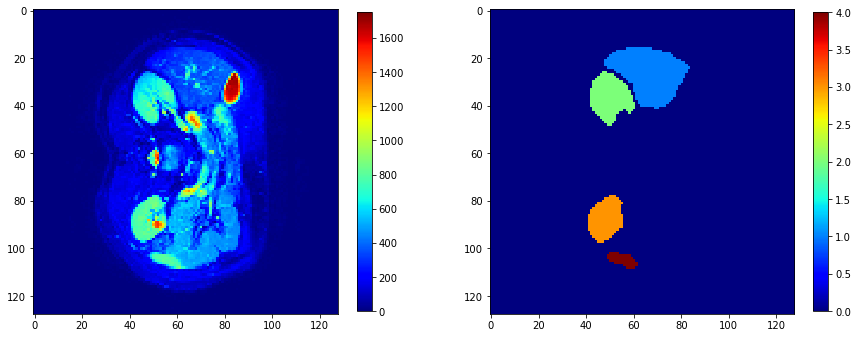

In [107]:
compare_2_images(image[:,:,d//2], mask[:,:,d//2], cmap1='jet', cmap2='jet', colorbar=True)

In [23]:
#for i in range(mask.shape[2]): plot_slice(mask, i)

# REMOVE BLACK SLICES

If we simply remove all black slices from each masks, we'll end up with masks of various depth, which isn't suitable for training. Thus we need to count the number of non black slices for each mask of the dataset, take the max of thoses values, and pad every reduced mask to this number of slices.

In [19]:
_, mask = load(ROOTDIR, image_list, mask_list, 6, target_resolution, target_shape)

In [20]:
min_z, max_z = get_labelled_depth_range(mask)

In [21]:
print(min_z, max_z)

0 31


In [29]:
max_range = 0
for i in range(len(image_list)):
    _, mask = load(ROOTDIR, image_list, mask_list, i, target_resolution, target_shape)
    select_classes(mask, (1, ))
    min_z, max_z = get_labelled_depth_range(mask)
    max_range = max(max_range, max_z - min_z)
    print(min_z, max_z, max_range)
print(max_range)

10 31 21
8 29 21
8 25 21
4 30 26
4 30 26
10 29 26
12 31 26
8 31 26
26


In [13]:
def get_labelled_depth_range(array_3D):
    nb_slices = array_3D.shape[2]
    num_non_black_pixels_per_slice = np.count_nonzero(array_3D, axis=(0,1))
    for z in range(nb_slices):
        if num_non_black_pixels_per_slice[z] > 0:
            min_z = z
            break
    for z in reversed(range(nb_slices)):
        if num_non_black_pixels_per_slice[z] > 0:
            max_z = z
            break
    return min_z, max_z

In [14]:
min_z, max_z = get_labelled_depth_range(mask)

In [ ]:
def get_reduced_depth

In [15]:
print(min_z, max_z)

10 31


In [71]:
def remove_black_slices(array_3D, padding=1):
    nb_slices = array_3D.shape[2]
    num_non_black_pixels_per_slice = np.count_nonzero(array_3D, axis=(0,1))
    for z in range(nb_slices):
        if num_non_black_pixels_per_slice[z] > 0:
            min_z = z
            break
    for z in reversed(range(nb_slices)):
        if num_non_black_pixels_per_slice[z] > 0:
            max_z = z
            break
    min_z = max(min_z-padding, 0)
    max_z = min(max_z+padding, nb_slices)
    return array_3D[:,:,min_z:max_z]

In [72]:
mask.shape

(128, 128, 32)

In [73]:
test_mask = remove_black_slices(mask)

In [74]:
test_mask.shape

(128, 128, 23)

# SELECT CLASSES

In [25]:
def select_classes(mask, class_indexes):
    all_classes = [1,2,3,4]
    classes_to_delete = list(filter(lambda x: x not in class_indexes, all_classes))
    for class_index in classes_to_delete:
        mask[mask== class_index] = 0

In [26]:
select_classes(mask, (1, ))

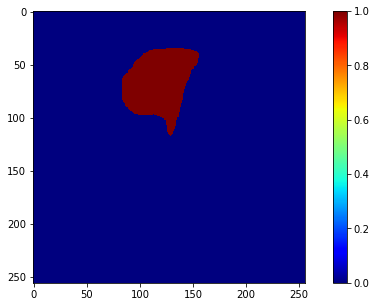

In [27]:
plot_slice(mask, d//2, figsize=(10,5), colorbar=True, cmap='jet')

# CUBIFY AND UNCUBIFY

Here is defined a function __cubify__ to split a big cube of shape (W, H, D) into N small cubes of shape  (w, h, d).   
Thus the input is a nd-array (W, H, D) and the output is a nd-array (N, w, h, d).   
Ofc this requires W%w=0, H%h=0, D%d=0.    
The inverse function __uncubify__ is also defined.

In [30]:
print("Big cube (ie complete mask) shape : ", mask.shape)

Big cube (ie complete mask) shape :  (256, 256, 26)


In [32]:
small_cube_shape = (64, 64, 26)

In [57]:
def cubify(arr, newshape):
    oldshape = np.array(arr.shape)
    repeats  = (oldshape / newshape).astype(int)
    tmpshape = np.column_stack([repeats, newshape]).ravel()
    order = np.arange(len(tmpshape))
    order = np.concatenate([order[::2], order[1::2]])
    # newshape must divide oldshape evenly or else ValueError will be raised
    return arr.reshape(tmpshape).transpose(order).reshape(-1, *newshape)

In [58]:
def uncubify(arr, oldshape):
    N, newshape = arr.shape[0], arr.shape[1:]
    oldshape = np.array(oldshape)    
    repeats  = (oldshape / newshape).astype(int)
    tmpshape = np.concatenate([repeats, newshape])
    order = np.arange(len(tmpshape)).reshape(2, -1).ravel(order='F')
    return arr.reshape(tmpshape).transpose(order).reshape(oldshape)

In [34]:
splitted_mask = cubify(mask, small_cube_shape)

In [59]:
unsplitted_mask = uncubify(splitted_mask, mask.shape)

In [60]:
print("Small cubes sequence (ie splitted mask) shape..: ", splitted_mask.shape)
print("Big cube (ie unsplitted mask) shape............: ", unsplitted_mask.shape)

Small cubes sequence (ie splitted mask) shape..:  (16, 64, 64, 26)
Big cube (ie unsplitted mask) shape............:  (256, 256, 26)


We can check that the unsplitted cube is truly the original mask (we'll also plot it). 

In [64]:
print(np.allclose(unsplitted_mask, mask))

True


In [53]:
def plot_splitted_mask_slice(splitted_mask, slice_index, figsize=(15,10), cmap=None, colorbar=False):
    nb_small_cubes = splitted_mask.shape[0]
    nb_rows, nb_columns = nb_small_cubes//4, 4
    fig, axes = plt.subplots(nb_rows, nb_columns, figsize=figsize)
    for i in range(nb_rows):
        for j in range(nb_columns):
            plot_ij = axes[i,j].imshow(splitted_mask[nb_rows*i+j,:,:,slice_index], cmap=cmap)
            axes[i,j].set_axis_off()
            if colorbar:
                fig.colorbar(plot_ij, ax=axes[i,j])
    plt.show()

See how the colorbar values differs. This plot is indeed showing a good split.

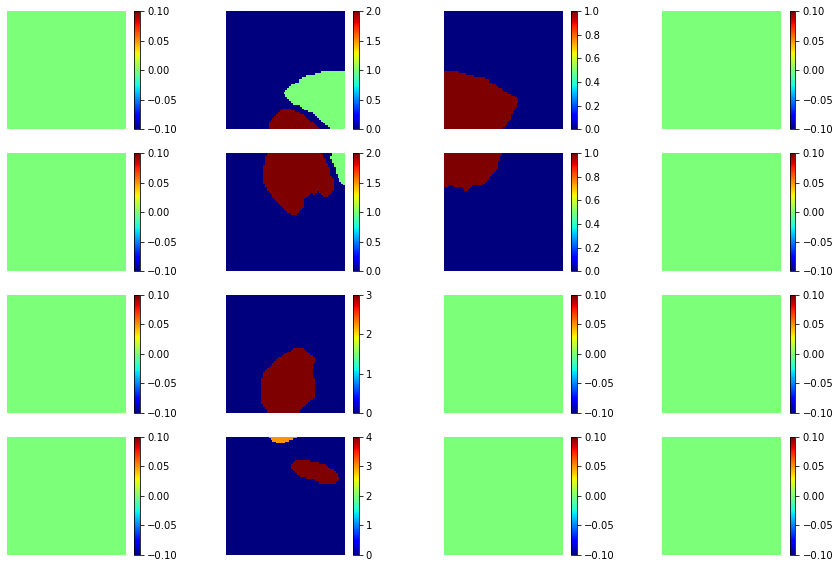

In [56]:
plot_splitted_mask_slice(splitted_mask, d//2, cmap='jet', colorbar=True)

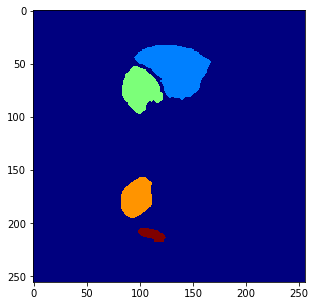

In [66]:
plot_slice(unsplitted_mask, d//2, cmap='jet', figsize=(10,5))

In [69]:
nb_small_cubes = splitted_mask.shape[0]
for i in range(nb_small_cubes):
    small_cube = splitted_mask[i,...]
    #print(small_cube.shape)
    #plot_slice(small_cube, d//2)

In [70]:
test = np.ndarray(splitted_mask.shape)

In [71]:
test.shape

(16, 64, 64, 26)